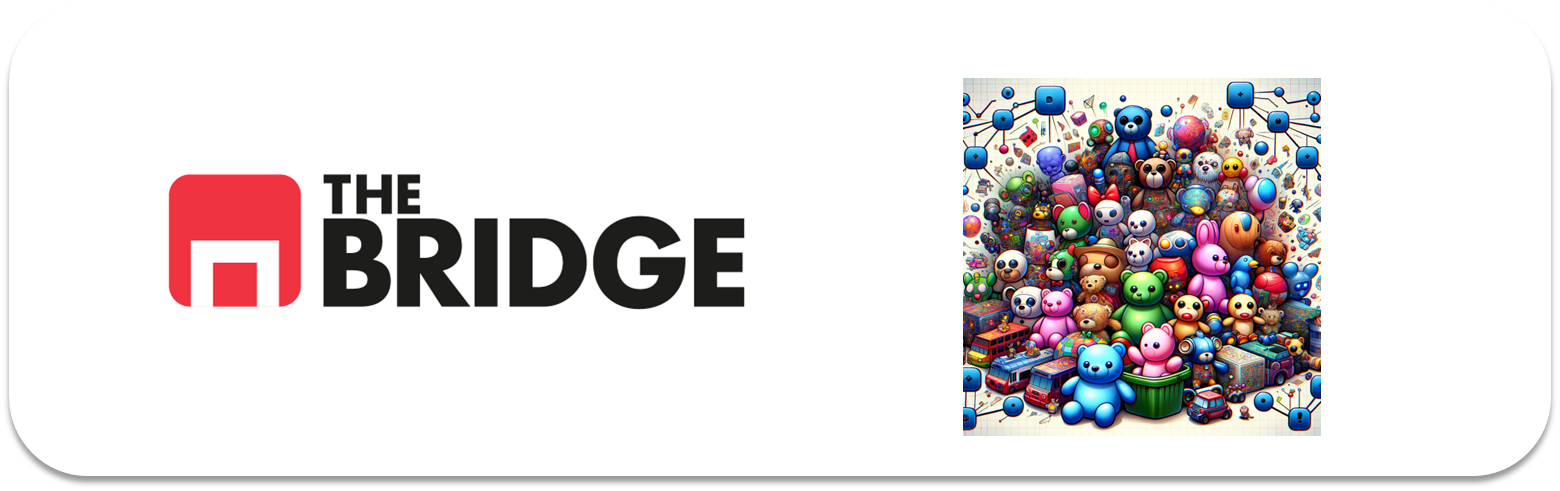

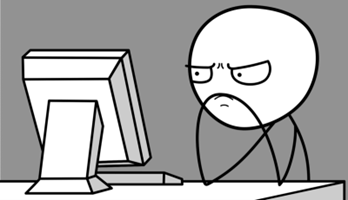

## PRACTICA OBLIGATORIA: DBSCAN y CLUSTERING JERARQUICO

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, ParameterGrid

import warnings
warnings.filterwarnings(action="ignore")

### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


1. ENTENDER EL PROBLEMA 

El objetivo es segmentar las mezclas de bebidas energéticas en distintos grupos utilizando algoritmos de clustering. DBSCAN será uno de los algoritmos, y también usaremos K-means, que es adecuado para este tipo de problemas.

2. CARGA DE DATOS Y VISUALIZACIÓN

In [2]:
# Cargar datos
data = pd.read_csv("./data/empowering_drinks.csv", delimiter= '|')
data.head()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.518613,0.232053,1.034819,1.013009,0.251717
1,0.246290,-0.827996,0.733629,0.965242,-0.293321
2,0.196879,1.109334,1.215533,1.395148,0.269020
3,1.691550,0.487926,1.466525,2.334574,1.186068
4,0.295700,1.840403,0.663351,-0.037874,-0.319276


In [3]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Azúcares,153.0,0.019231,1.026182,-2.434235,-0.816038,0.061000,0.876275,2.259772
Vitamínas del grupo B,153.0,0.037273,0.995984,-3.679162,-0.499016,-0.023821,0.707247,3.156325
Cafeína,153.0,0.041057,1.040928,-1.695971,-1.043392,0.211566,0.894264,3.062832
Ácido Cítrico,153.0,0.080022,1.009450,-1.493188,-0.738463,-0.165254,0.917474,2.971473
Taurina,153.0,-0.044088,0.934399,-1.634288,-0.799428,-0.154899,0.493956,2.431870


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               153 non-null    float64
 1   Vitamínas del grupo B  153 non-null    float64
 2   Cafeína                153 non-null    float64
 3   Ácido Cítrico          153 non-null    float64
 4   Taurina                153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


3. MINIEDA: SELECCIÓN DE FEATURES

Visualizamos las features dos a dos para entender mejor las relaciones entre ellas.

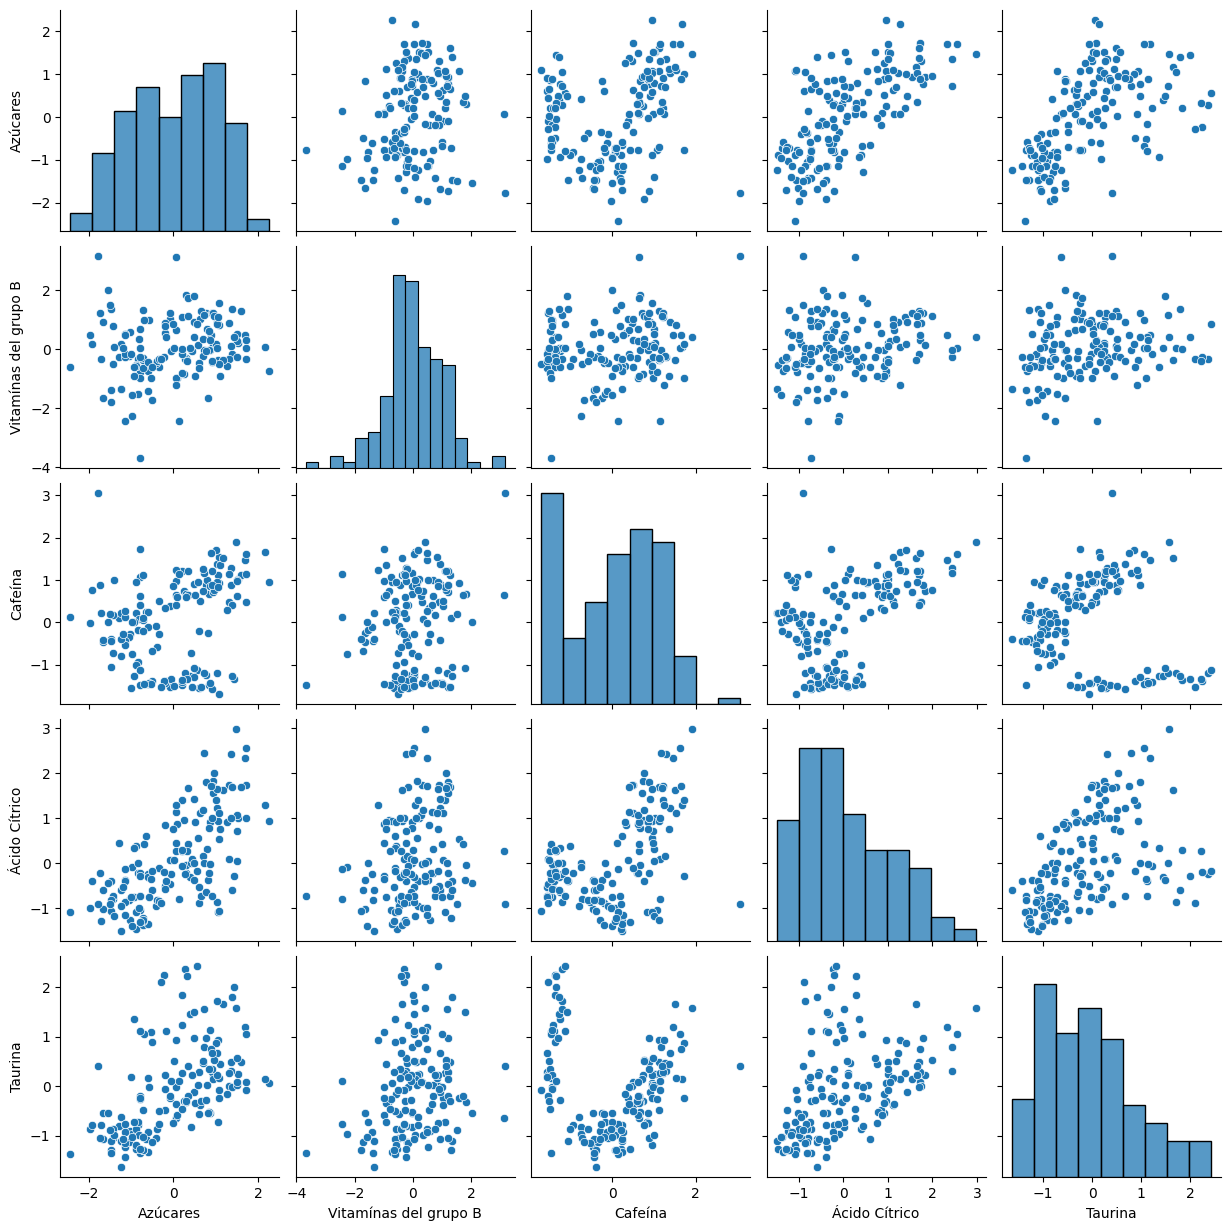

In [5]:
# Visualización de pares de features
sns.pairplot(data)
plt.show()

Las unicas Features en las que veo algo de sentido y una posible combinacion de clusters son Taurina y Cafeina, las demas parecen manchas grandes.

4. TRATAMIENTO DE FEATURES

Las features parecen tratadas y no hay que tocar nada.

In [6]:
features = ['Cafeína', 'Taurina']
X = data[features]

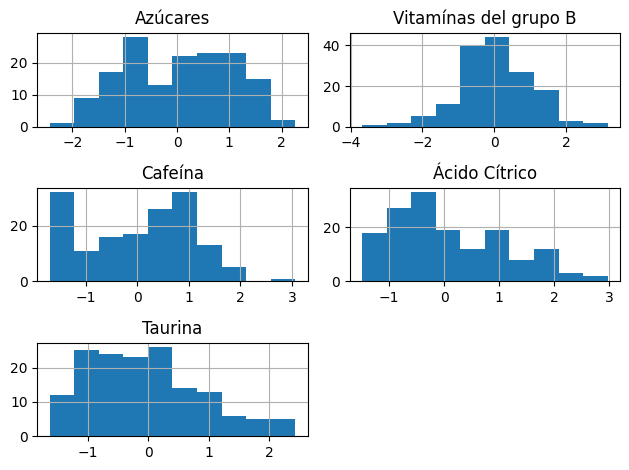

In [7]:
data.hist()
plt.tight_layout()

5. SELECCIÓN DE MODELOS E HIPERPARÁMETROS.

- Algoritmo 1: K-means

Dado que los químicos esperan entre 3 y 5 segmentos, probamos K-means con diferentes números de clusters.

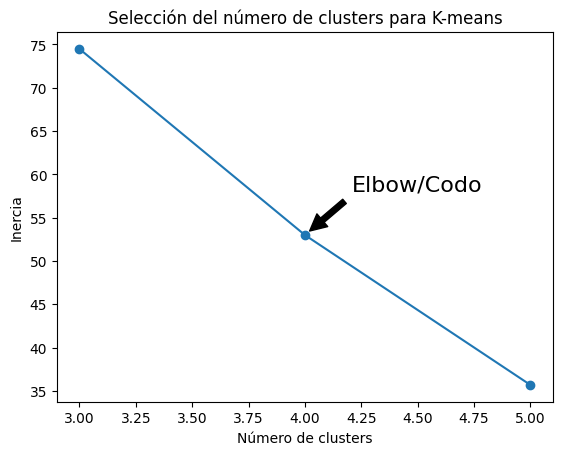

In [8]:
# Probar K-means con 3, 4 y 5 clusters
inertia = []
for k in range(3, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Visualización de la inercia
plt.plot(range(3, 6), inertia, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.annotate('Elbow/Codo',
             xy=(4, inertia[1]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
)
plt.title('Selección del número de clusters para K-means')
plt.show()


Seleccionamos 4 clusters, basado en el 'codo' de la gráfica de inercia.

- Algoritmo 2: DBSCAN

Para DBSCAN, probamos diferentes combinaciones de eps y min_samples para encontrar la mejor segmentación.

In [9]:
param_grid = {
    'eps': np.arange(0.1, 1.5, 0.1),
    'min_samples': range(3, 6)
}

best_params = None
best_outlier_percent = float('inf')
best_labels = None

for params in ParameterGrid(param_grid):
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    labels = dbscan.fit_predict(X)
    
    # Calcular el porcentaje de outliers
    perc_outliers = 100 * np.sum(labels == -1) / len(labels)
    
    # Verificar si es el mejor porcentaje de outliers encontrado
    if perc_outliers < best_outlier_percent:
        best_outlier_percent = perc_outliers
        best_params = params
        best_labels = labels

print(f"Mejores parámetros para DBSCAN: eps={best_params['eps']}, min_samples={best_params['min_samples']}")
print(f"Porcentaje de outliers: {best_outlier_percent:.2f}%")

Mejores parámetros para DBSCAN: eps=0.5, min_samples=3
Porcentaje de outliers: 0.65%


In [10]:
param_grid_kmeans = {
    'n_clusters': range(2, 6)  # Probar con 2, 3, 4, 5, 6 y 7 clusters
}

kmeans = KMeans(random_state=42)

grid_search_kmeans = GridSearchCV(kmeans, param_grid_kmeans, cv=5)
grid_search_kmeans.fit(X)

best_kmeans_params = grid_search_kmeans.best_params_
best_kmeans_labels = grid_search_kmeans.best_estimator_.labels_

print(f"Mejores parámetros para K-means: {best_kmeans_params}")


Mejores parámetros para K-means: {'n_clusters': 5}


6. ENTRENAMIENTO Y VISUALIZACIÓN DE RESULTADOS

- Resultados de K-means

In [11]:
best_k = 5
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans.fit(X)
kmeans_labels = kmeans.predict(X)


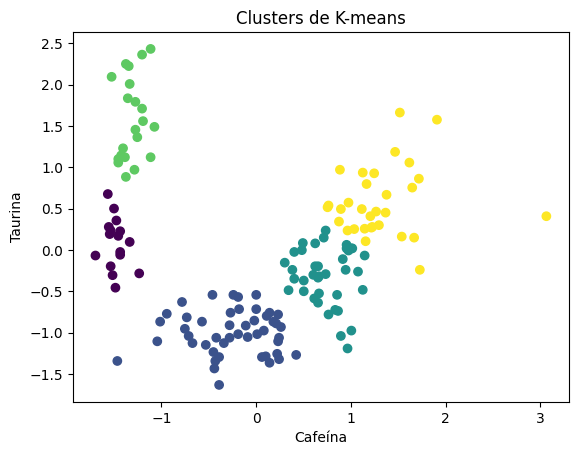

In [12]:
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=kmeans_labels, cmap='viridis')
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.title('Clusters de K-means')
plt.show()

In [13]:
dbscan = DBSCAN(eps = 0.5, min_samples = 4)
dbscan.fit(X)
dbscan_labels = dbscan.labels_
data['Cluster'] = dbscan_labels

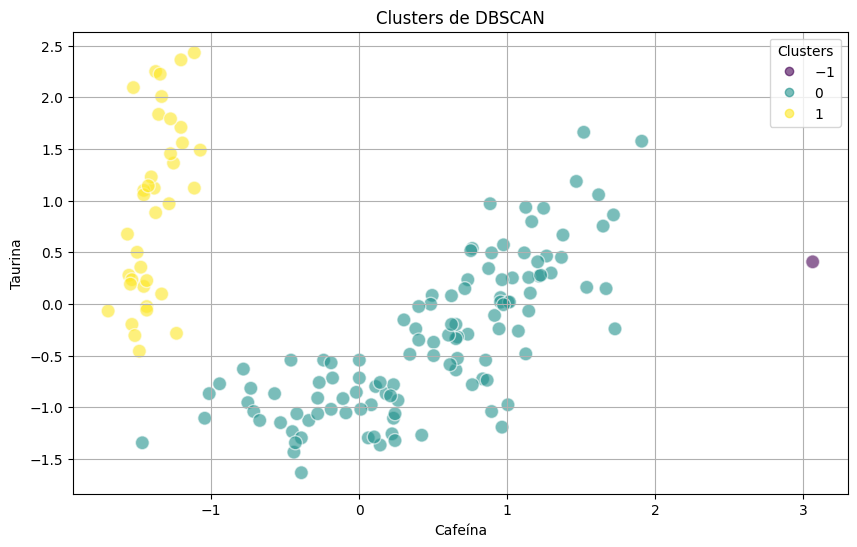

In [14]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=best_labels, cmap='viridis', s=100, alpha=0.6, edgecolors='w')
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.title('Clusters de DBSCAN')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.grid(True)
plt.show()

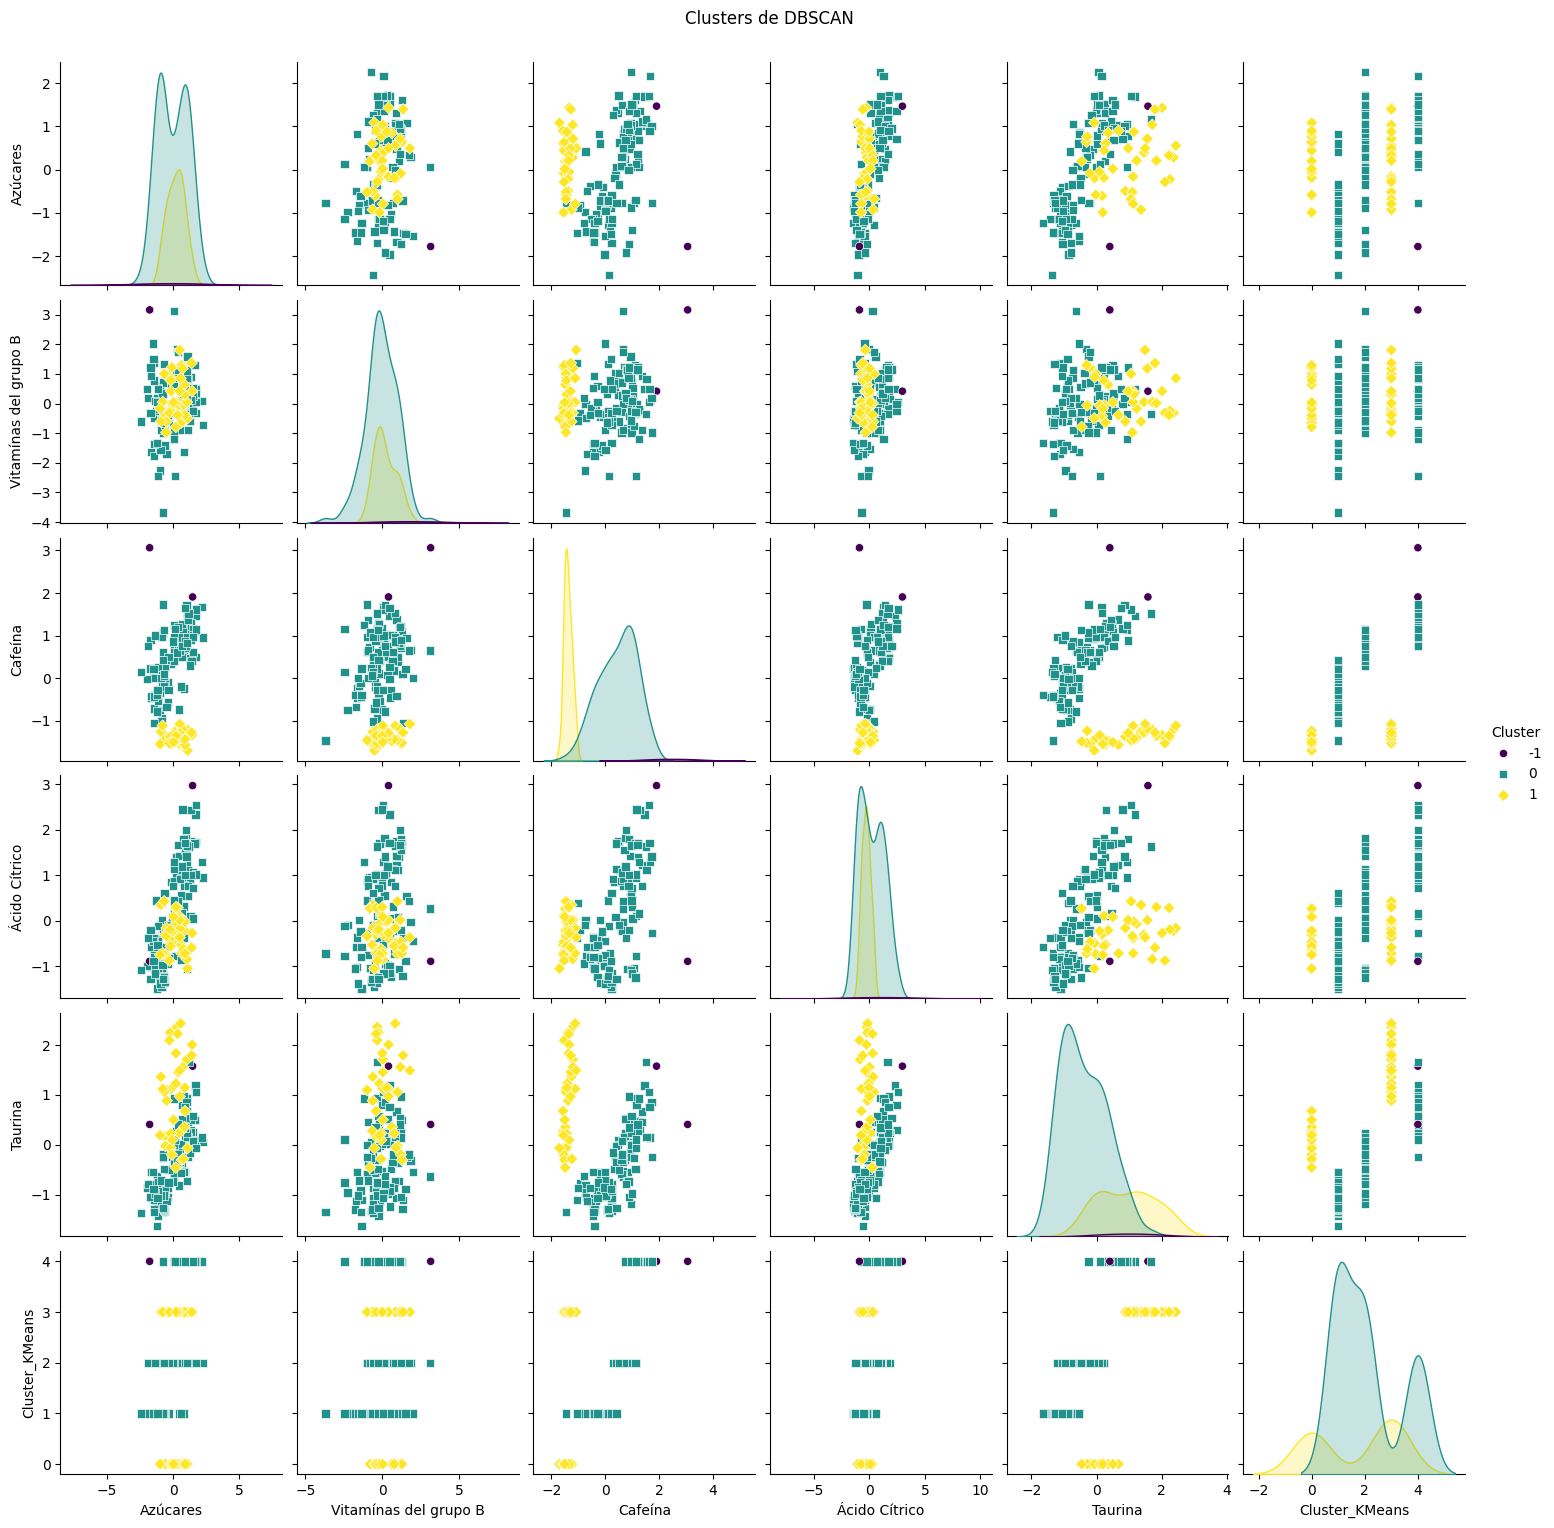

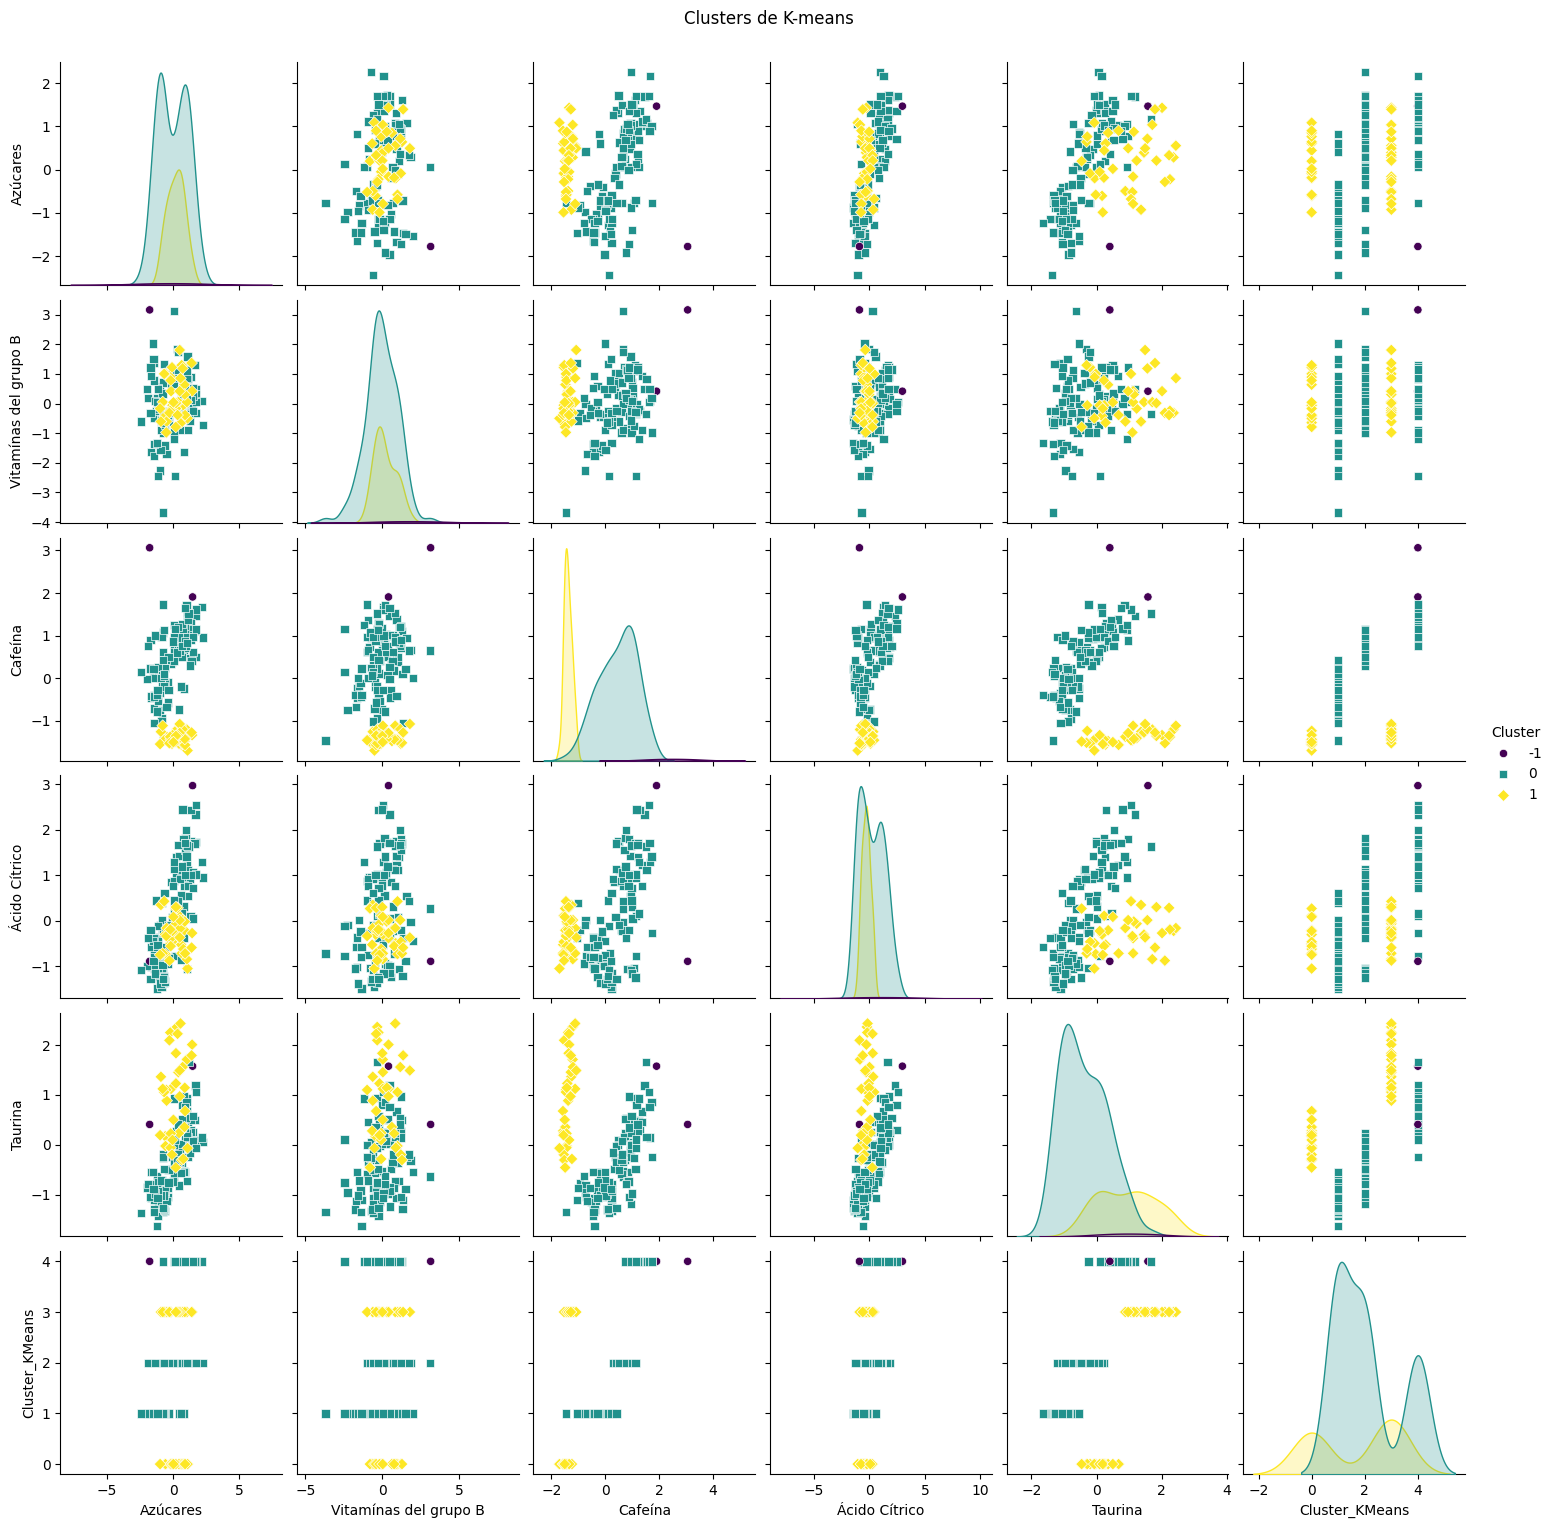

In [15]:
data['Cluster_KMeans'] = best_kmeans_labels
sns.pairplot(data, hue='Cluster', palette='viridis', diag_kind='kde', markers=["o", "s", "D", "P", "X", "v"])
plt.suptitle('Clusters de DBSCAN', y=1.02)
plt.show()

sns.pairplot(data, hue='Cluster', palette='viridis', diag_kind='kde', markers=["o", "s", "D", "P", "X", "v"])
plt.suptitle('Clusters de K-means', y=1.02)
plt.show()

### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

In [16]:
new_experiments = pd.read_csv("./data/new_experiments.csv", delimiter= '|')

new_experiments.head()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.481555,0.305159,1.366128,2.239039,0.731870
1,0.616869,0.890014,0.583034,0.312420,-0.665332
2,-1.680724,0.341713,-0.340615,-0.213021,-0.976782
3,-0.284874,-1.412851,-0.782361,-1.193845,-0.717240
4,-0.927212,0.634140,-1.565455,-0.085641,-0.522583


In [17]:
new_experiments.describe().T

,count,mean,std,min,25%,50%,75%,max
Azúcares,6.0,0.028059,1.205271,-1.680724,-0.766628,0.165997,0.876275,1.481555
Vitamínas del grupo B,6.0,0.085839,0.826463,-1.412851,-0.106066,0.323436,0.561033,0.890014
Cafeína,6.0,-0.348982,1.139233,-1.565455,-1.211557,-0.561488,0.352122,1.366128
Ácido Cítrico,6.0,0.106490,1.157346,-1.193845,-0.368265,-0.149331,0.212905,2.239039
Taurina,6.0,-0.032337,1.143657,-0.976782,-0.704263,-0.593957,0.418256,1.956043


In [18]:
new_experiments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               6 non-null      float64
 1   Vitamínas del grupo B  6 non-null      float64
 2   Cafeína                6 non-null      float64
 3   Ácido Cítrico          6 non-null      float64
 4   Taurina                6 non-null      float64
dtypes: float64(5)
memory usage: 372.0 bytes


In [19]:
new_X = new_experiments[features]

In [20]:
# Normalización de los nuevos datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(new_X)
new_X_scaled = scaler.transform(new_X)
new_X_scaled

array([[ 1.64918715,  0.73199114],
       [ 0.89619243, -0.60630964],
       [ 0.00804482, -0.90463055],
       [-0.41672144, -0.65602979],
       [-1.16971616, -0.46957922],
       [-0.96698681,  1.90455807]])

In [21]:
new_X_scaled.shape

(6, 2)

In [22]:
# Predecir clusters para los nuevos experimentos
new_labels = kmeans.predict(new_X_scaled)

# Añadir las etiquetas predichas al dataframe de nuevos experimentos
new_experiments['Cluster'] = new_labels
new_experiments


,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina,Cluster
0,1.481555,0.305159,1.366128,2.239039,0.731870,4
1,0.616869,0.890014,0.583034,0.312420,-0.665332,2
2,-1.680724,0.341713,-0.340615,-0.213021,-0.976782,1
3,-0.284874,-1.412851,-0.782361,-1.193845,-0.717240,1
4,-0.927212,0.634140,-1.565455,-0.085641,-0.522583,0
5,0.962743,-0.243142,-1.354622,-0.420013,1.956043,3


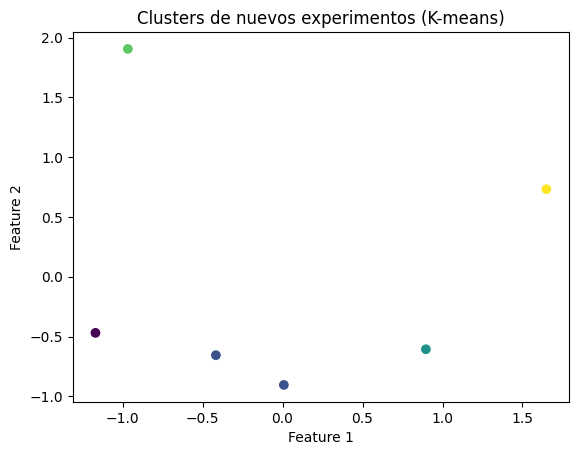

In [23]:
# Visualización de los nuevos experimentos en sus clusters
plt.scatter(new_X_scaled[:, 0], new_X_scaled[:, 1], c=new_labels, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clusters de nuevos experimentos (K-means)')
plt.show()


In [24]:
# Guardar las etiquetas predichas en un archivo CSV
new_experiments.to_csv("./data/new_experiments_labeled.csv", index=False)


### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.